In [2]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Introduction and scenario
I am a junior data analyst working on the marketing analyst team at Bellabeat, a high-tech manufacturer of health-focused products for women. Bellabeat is a successful small company, but they have the potential to become a larger player in the global smart device market. Urška Sršen, cofounder and Chief Creative Officer of Bellabeat, believes that analyzing smart device fitness data could help unlock new growth opportunities for the company. I have been asked to focus on one of Bellabeat’s products and analyze smart device data to gain insight into how consumers are using their smart devices. The insights I discover will then help guide marketing strategy for the company. I will present my analysis to the Bellabeat executive team along with my high-level recommendations for Bellabeat’s marketing strategy.

In order to answer the key business questions, I will follow the steps of the data analysis process: **ask, prepare, process, analyze, share,** and **act**.

## 2. Data source
Sršen encourages me to use [FitBit Fitness Tracker Data](https://www.kaggle.com/arashnic/fitbit) that explores smart device users’ daily habits.

This Kaggle data set contains personal fitness tracker from thirty FitBit users. Thirty eligible Fitbit users consented to the submission of personal tracker data, including minute-level output for physical activity, heart rate, and sleep monitoring. It includes information about daily activity, steps, and heart rate that can be used to explore users’ habits.

## 3. Data analysis and visualization
First, I need to install and load the necessary packages for this analysis.

In [3]:
library(tidyverse)
install.packages("skimr")
library(skimr)

### A. Cleaning of data
We have a quick look on the csv file of daily activity.

In [4]:
daily_activity <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")

In [5]:
head(daily_activity)
n_distinct(daily_activity$Id)

We have 33 users' record. Then I would like to verify the data provided.

In [6]:
check <- daily_activity %>%
  select(Id, ActivityDate, TotalDistance, TrackerDistance) %>%
  mutate(diff = TotalDistance - TrackerDistance) %>%
  filter(diff != 0)
n_distinct(check)
distinct(check, Id)

There are 15 data entries with TotalDistance differing from TrackerDistance, which are from user ID **6962181067** and **7007744171**. In the coming analysis about activities, I would not include their data.

### B. Heartrate
Let's investigate the data about heartrate.

In [7]:
heartrate <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv")
head(heartrate)

In [8]:
heartrate_summary <- 
  heartrate %>%
  group_by(Id) %>%
  summarise(max_value = max(Value),
            min_value = min(Value))
print(heartrate_summary)

I will try to use the maximum values with bpm range studied to figure out the FitBit users' age.

In [9]:
qplot(heartrate_summary$max_value,
      geom="histogram",
      binwidth = 10,  
      main = "Histogram for Heartrate", 
      xlab = "Heartrate",  
      fill=I("blue"), 
      col=I("red"), 
      alpha=I(.2),
      xlim=c(100,220))

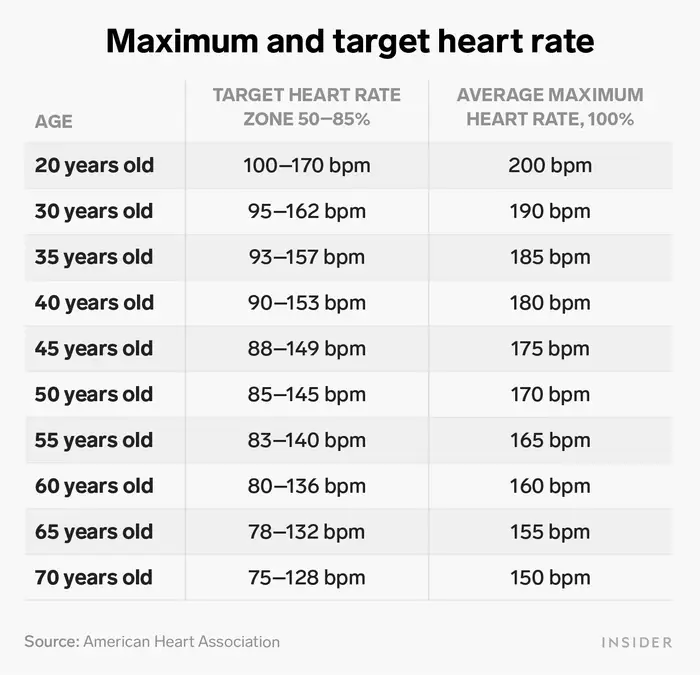

Combining with the data above, we can know that the main users' age range is around 30-45 years old.

*Data source: <https://www.insider.com/what-is-a-good-resting-heart-rate>*

Although we have the above-mentioned finding, it is just a rough idea as there are only 14 out of 30 users having such records in the dataset.

### C. Activity (Calories, Intensities, Steps)
Let's explore the data about activitiy of FitBit users.

In [10]:
daily_data <- daily_activity %>%
  filter(Id != 6962181067 & Id != 7007744171)
colnames(daily_data)

In [11]:
daily_data_summary <- daily_data %>%
  group_by(Id) %>%
  summarise(mean_step = mean(TotalSteps),
            mean_distance = mean(TrackerDistance),
            mean_VeryActiveDistance = mean(VeryActiveDistance),
            mean_ModeratelyActiveDistance = mean(ModeratelyActiveDistance),
            mean_LightActiveDistance = mean(LightActiveDistance),
            mean_SedentaryActiveDistance = mean(SedentaryActiveDistance),
            mean_VeryActiveMinutes = mean(VeryActiveMinutes),
            mean_ModeratelyActiveMinutes = mean(FairlyActiveMinutes),
            mean_LightlyActiveMinutes = mean(LightlyActiveMinutes),
            mean_SedentaryActiveMinutes = mean(SedentaryMinutes),
            mean_Calories = mean(Calories),
            count = n_distinct(ActivityDate))
skim(daily_data_summary)

In [12]:
mindate_activity <- min(daily_data$ActivityDate)
maxdate_activity <- max(daily_data$ActivityDate)

In [13]:
ggplot(data=daily_data, aes(x=TotalSteps, y=SedentaryMinutes, color = Id)) +
  geom_point() +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5)) +
  labs(title = "Sedentary Minutes v.s Total Steps per day", 
       caption = paste0("Data from: ", mindate_activity, " to ", maxdate_activity))

In [14]:
hourly_calories <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlyCalories_merged.csv")
colnames(hourly_calories)
hourly_intensities <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv")
colnames(hourly_intensities)
hourly_steps <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv")
colnames(hourly_steps)

In [15]:
hourly_calories_clean <- hourly_calories %>%
  unite("Id_DateHour", Id:ActivityHour, remove = TRUE)
hourly_steps_clean <- hourly_steps %>%
  unite("Id_DateHour", Id:ActivityHour, remove = TRUE)
hourly_intensities_clean <- hourly_intensities %>%
  unite("Id_DateHour", Id:ActivityHour, remove = FALSE)
hourly_data_temp <- merge(hourly_intensities_clean, hourly_calories_clean, by="Id_DateHour")
hourly_data <- merge(hourly_data_temp, hourly_steps_clean, by="Id_DateHour") %>%
  filter(Id != 6962181067 & Id != 7007744171)
colnames(hourly_data)

In [16]:
ggplot(data = hourly_data) +
  geom_point(mapping = aes(x = TotalIntensity, y = Calories, color = Id)) +
  labs(title = "Calories v.s Total Intensity per hour", 
       caption = paste0("Data from: ", mindate_activity, " to ", maxdate_activity))

In [17]:
ggplot(data = hourly_data) +
  geom_point(mapping = aes(x = StepTotal, y = Calories, color = Id)) +
  labs(title = "Calories v.s Total Steps per hour", 
       caption = paste0("Data from: ", mindate_activity, " to ", maxdate_activity))

The higher the intensities of activities/number of steps, the more the calories burned.

### D. Sleeping time
Let's explore the data about sleeping time.

In [18]:
sleep_day <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
colnames(sleep_day)

In [19]:
sleep_day_summary <- sleep_day %>%
  group_by(Id) %>%
  summarise(mean_records = mean(TotalSleepRecords),
            mean_sleep = mean(TotalMinutesAsleep),
            mean_bed = mean(TotalTimeInBed),
            count = n_distinct(SleepDay)) %>%
  mutate(diff = mean_bed - mean_sleep)
head(sleep_day_summary)

We can see that the count of data for each user varies. To avoid any bias/outstanding case/mistake of data, I will filter the user with less than 10 sleeping day records.

In [20]:
sleep_day_summary_clean <- sleep_day_summary %>%
  filter(count >= 10) %>%
  arrange(diff)
head(sleep_day_summary_clean)

Let's recall the summary about sleeping time. We observed that the number of sleeping records, the time of sleeping and being on bed seems reasonable. Here we will explore the relationship with activity data.

In [21]:
head(sleep_day_summary_clean %>%
  select(Id, mean_sleep, mean_bed, diff))

We first need to clean the sleepDay data and create the key by combining user ID and date.

In [22]:
sleep_day_clean <- sleep_day %>%
  filter(Id %in% sleep_day_summary_clean$Id) %>%
  separate(SleepDay, c("Date", "Time"), sep = " ") %>%
  mutate(diff = TotalTimeInBed - TotalMinutesAsleep) %>%
  unite("key", Id:Date, remove = FALSE)
head(sleep_day_clean)

Then, we need to import and clean dailyCalories data set and create the key by the same way as above.

In [23]:
daily_calories <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv")
daily_calories_clean <- daily_calories %>%
  unite("key", Id:ActivityDay, remove = FALSE) %>%
  select(key, Calories)
head(daily_calories_clean)

Let's merge 2 data sets.

In [24]:
sleep_day_calories <- merge(sleep_day_clean, daily_calories_clean, by="key")
head(sleep_day_calories)

Let's plot to see if there is any observation.

In [25]:
ggplot(data = sleep_day_calories) +
  geom_point(mapping = aes(x = TotalMinutesAsleep, y = TotalTimeInBed, color = Id))

The graph shows a positve linear relationship with few outliers, which possibly from the same user.

In [26]:
ggplot(data = sleep_day_calories) +
  geom_point(mapping = aes(x = TotalTimeInBed, y = Calories, color = Id))

In [27]:
ggplot(data = sleep_day_calories) +
  geom_point(mapping = aes(x = TotalMinutesAsleep, y = Calories, color = Id))

In [28]:
ggplot(data = sleep_day_calories) +
  geom_point(mapping = aes(x = diff, y = Calories, color = Id))

From above 3 graphs, users usually stay in bed for 400-600 minutes and sleep for 350-550 minutes per night. The difference is majorly in the range from 0-50 minutes, which has no significant relationship with calories.

### E. Weight
There is another CSV file about weight log of users. Let's see if there is any useful insight to be discovered.

In [29]:
weight_log <- read.csv("../input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")
head(weight_log)

As there is not all users having records on weight log, I need to take some samples to do further analysis and I prefer to choose those with auto input so that the human error could be minimized.

In [30]:
weight_log_auto <- weight_log %>%
  select(Id, Date, IsManualReport) %>%
  filter(IsManualReport == "False") %>%
  group_by(Id) %>%
  summarise(record_number = n_distinct(Date))
head(weight_log_auto)

As there is only 1 user with relatively complete records of weight log, I will choose this user as a sample.

In [31]:
weight_log_cleaned <- weight_log %>%
  tidyr::separate(Date, c("Date", "Time"), sep = " ") %>%
  select(Id, Date, WeightKg, BMI) %>%
  filter(Id == 8877689391)
head(weight_log_cleaned)

We focus on this user and see the trend of his/her weight change with date.

In [32]:
mindate_weight <- min(weight_log_cleaned$Date)
maxdate_weight <- max(weight_log_cleaned$Date)

In [33]:
ggplot(data=weight_log_cleaned, aes(x=Date, y=WeightKg, group=1)) +
  geom_line() +
  geom_point() +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5)) +
  labs(title="Trend of weight in kg (User ID: 8877689391)",
       caption=paste0("Data from: ", mindate_weight, " to ", maxdate_weight))

As there is no obvious trend in weight as shown above, I will not use "weightLogInfo_merged.csv" in the analysis.
However, we can have a rough idea for customers' BMI:

In [34]:
mean(weight_log_cleaned$BMI)

It is at the marginal case within the standard.

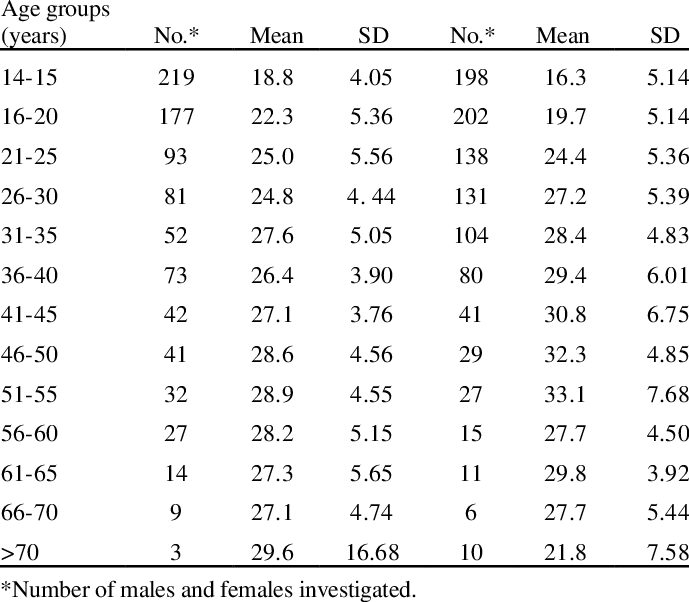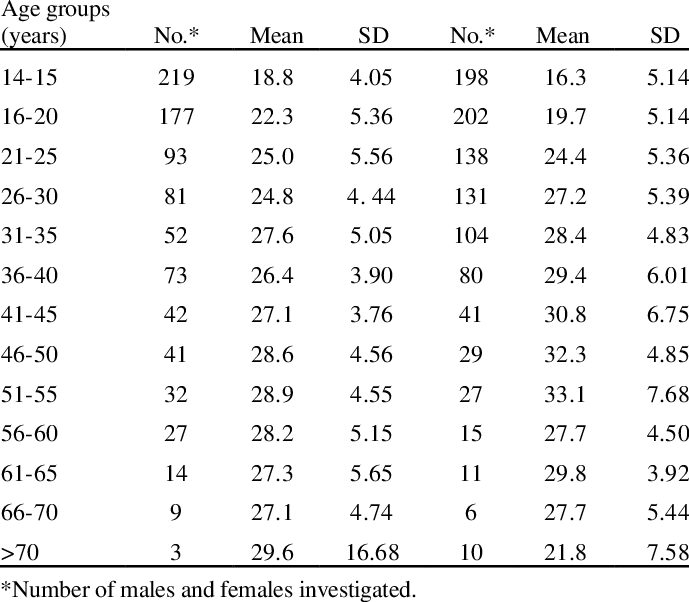

**Body mass index (BMI) in normal males and females of different groups. BMI (left: male, right: female)**

*Data source: <https://www.researchgate.net/figure/Body-mass-index-BMI-in-normal-males-and-females-of-different-groups-BMI-male-BMI_tbl1_6437262>*

### F. MET
As I have no information about what MET is, I will not use "minuteMETsNarrow_merged.csv" in the analysis.

## 4. High-level content recommendations based on analysis
After all, our product should add the following features:
* Alert for not enough sleeping time per day
* Alert for not enough steps per hour
* Remind for inputing weight log
* Add feature for recording height

And we have some key findings through the data analysis and find out the characteristics of our potential customers:
* Sex: Female (fixed by company)
* Age: 30-45
* With high sedentary minutes and low steps per day
* Most likely works in office or from home without much exercise
* High BMI: 25.48 from data, which is nearly overweighted

On the other hand, from the available data, we cannot find any data about water intake for users, which means that there is possibly no similar product from our competitors. We can take this opportunity and competitive advantage to promote more on **Spring**, which is a water bottle that tracks daily water intake using smart technology to ensure that users are
appropriately hydrated throughout the day, with connection to our current Bellabeat app.